In this notebook we study overfitting.

In [1]:
# General imports
import numpy as np
import torch

# DeepMoD Components
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN, Siren
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training import train
from multitaskpinn.training.sparsity_scheduler import Periodic

# Data
from phimal_utilities.data import Dataset
from phimal_utilities.data.kdv import DoubleSoliton

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'running on {device}')
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

running on cuda


In [2]:
# Making data
x = np.linspace(-7, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=(5, 2), x0=(-3, -1))


X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=False, random=False)

Text(0, 0.5, 't')

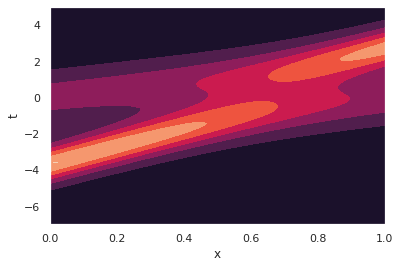

In [3]:
plt.contourf(t_grid, x_grid, y_full.reshape(x_grid.shape))
plt.xlabel('x')
plt.ylabel('t')

Now we sample on a square grid:

In [4]:
# Making training set
x_sample = np.linspace(-7, 5, 50)
t_sample = np.linspace(0.0, 1.0, 40)
x_grid_sample, t_grid_sample = np.meshgrid(x_sample, t_sample, indexing='ij')
X_train, y_train = dataset.create_dataset(x_grid_sample.reshape(-1, 1), t_grid_sample.reshape(-1, 1), n_samples=0, noise=0.1, normalize=True, random=True)

In [5]:
(0.1 * torch.std(y_train))**2

tensor(0.0041)

# Baseline NN

In [7]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=10000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [8]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, delta=0.00, log_dir='runs/NN_overfitting/', max_iterations=5000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       5000    100.00%               0s   -7.29e+00   4.15e-03   1.49e-05   3.25e+00 

In [9]:
model.estimator_coeffs()

In [10]:
model.constraint_coeffs(sparse=True, scaled=True)

[tensor([[ 1.3103e-03],
         [ 4.7471e-02],
         [ 2.2012e-02],
         [-9.1643e-01],
         [-1.6093e-02],
         [-1.9011e+00],
         [-1.7324e-02],
         [-2.9184e-02],
         [ 5.4334e-03],
         [ 1.7729e-01],
         [-1.2693e-02],
         [ 9.9078e-02]], grad_fn=<MaskedScatterBackward>)]

So it did that in a single run basically. Now let's check out SIREN.

# SIREN

In [11]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=10000, periodicity=50) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [12]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/SIREN_overfitting/', delta=0.00, max_iterations=5000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       5000    100.00%               0s   -7.32e+00   4.04e-03   9.37e-05   3.53e+00 

In [13]:
model.estimator_coeffs()

In [14]:
model.constraint_coeffs(sparse=True, scaled=False)

[tensor([[-1.2541e-02],
         [ 2.2286e-02],
         [ 2.6633e-03],
         [-2.4567e-03],
         [-1.2080e-02],
         [-5.6996e-01],
         [-2.8652e-03],
         [-1.9265e-05],
         [ 3.7623e-04],
         [ 3.6974e-02],
         [ 6.0692e-04],
         [ 7.5473e-05]], grad_fn=<MaskedScatterBackward>)]

In [15]:
model.constraint_coeffs(scaled=True, sparse=True)

[tensor([[-9.4260e-03],
         [ 5.6501e-02],
         [ 6.9666e-02],
         [-9.3675e-01],
         [-7.9243e-03],
         [-1.9354e+00],
         [-1.3563e-01],
         [-1.2943e-02],
         [ 3.9471e-04],
         [ 2.0744e-01],
         [ 5.9945e-02],
         [ 9.6291e-02]], grad_fn=<MaskedScatterBackward>)]

In [16]:
model.sparsity_masks

[tensor([True, True, True, True, True, True, True, True, True, True, True, True])]

Overfitting doesn't appear to be a very big issue; that means if we start the sparsity very late we wouldnt have an issue... Let's see: